In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, Input
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
import random
import tensorflow as tf
from keras.optimizers import Adam


# Set random seed for reproducibility
def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

set_seed(42)

/root/autodl-tmp/miniconda3/envs/cytf/lib/python3.12/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
2024-07-20 19:41:03.547986: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-20 19:41:03.548687: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could n

In [2]:
# Define the number of time steps and forecast steps
time_steps = 30      # Number of time steps used as input
forecast_steps = 7   # Number of steps to forecast

In [3]:
# Load data
df = pd.read_csv('/root/autodl-tmp/7.18_SDGPrediction/data/FB_SDG_3.csv')
data = df.iloc[:, 1].values

# Prepare dataset
def create_dataset(data, time_steps=1, forecast_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps - forecast_steps + 1):
        X.append(data[i:(i + time_steps)])
        y.append(data[(i + time_steps):(i + time_steps + forecast_steps)])
    return np.array(X), np.array(y)

X, y = create_dataset(data, time_steps, forecast_steps)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Standardize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

# Train and predict with Linear Regression
print("Training Linear Regression...")
lr_model = LinearRegression()
lr_model.fit(X_train.reshape(X_train.shape[0], -1), y_train.reshape(y_train.shape[0], -1))
lr_pred = lr_model.predict(X_test.reshape(X_test.shape[0], -1)).reshape(y_test.shape)

# Train and predict with Lasso Regression
print("Training Lasso Regression...")
lasso_model = Lasso(alpha=0.001)
lasso_model.fit(X_train.reshape(X_train.shape[0], -1), y_train.reshape(y_train.shape[0], -1))
lasso_pred = lasso_model.predict(X_test.reshape(X_test.shape[0], -1)).reshape(y_test.shape)

# Train and predict with KNN
print("Training KNN...")
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_pred = np.zeros_like(y_test)
for i in range(y_test.shape[0]):
    input_seq = X_test[i].reshape(1, -1)
    for j in range(forecast_steps):
        knn_model.fit(X_train.reshape(X_train.shape[0], -1), y_train[:, j])
        pred = knn_model.predict(input_seq)
        knn_pred[i, j] = pred[0]
        input_seq = np.roll(input_seq, -1)
        input_seq[0, -1] = pred[0]

# Train and predict with Random Forest
print("Training Random Forest...")
rf_model = RandomForestRegressor()
rf_model.fit(X_train.reshape(X_train.shape[0], -1), y_train.reshape(y_train.shape[0], -1))
rf_pred = rf_model.predict(X_test.reshape(X_test.shape[0], -1)).reshape(y_test.shape)

# Train and predict with XGBoost
print("Training XGBoost...")
xgb_model = XGBRegressor()
xgb_model.fit(X_train.reshape(X_train.shape[0], -1), y_train.reshape(y_train.shape[0], -1))
xgb_pred = xgb_model.predict(X_test.reshape(X_test.shape[0], -1)).reshape(y_test.shape)

# Train and predict with LSTM
print("Training LSTM...")
X_train_lstm = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_lstm = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(time_steps, 1)))
lstm_model.add(Dense(forecast_steps))
optimizer = Adam(learning_rate=0.001)
lstm_model.compile(optimizer=optimizer, loss='mse')
lstm_model.fit(X_train_lstm, y_train, epochs=50, batch_size=32, verbose=1)
lstm_pred = lstm_model.predict(X_test_lstm).reshape(y_test.shape)

# Train and predict with GRU
print("Training GRU...")
X_train_gru = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_gru = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
gru_model = Sequential()
gru_model.add(Input(shape=(time_steps, 1)))
gru_model.add(GRU(50, activation='relu', return_sequences=True))
gru_model.add(GRU(50, activation='relu'))
gru_model.add(Dense(forecast_steps))
optimizer = Adam(learning_rate=0.001)
gru_model.compile(optimizer=optimizer, loss='mse')
gru_model.fit(X_train_gru, y_train, epochs=50, batch_size=32, verbose=1)
gru_pred = gru_model.predict(X_test_gru).reshape(y_test.shape)

Training Linear Regression...
Training Lasso Regression...
Training KNN...
Training Random Forest...
Training XGBoost...
Training LSTM...
Epoch 1/50


2024-07-20 19:41:21.837005: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/root/autodl-tmp/miniconda3/envs/cytf/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 3.7253
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.8690
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.3050
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.2080
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1863
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1794
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1761
Epoch 8/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1740
Epoch 9/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1724
Epoch 10/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1710
Epoch 11/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1699
Epoch 12/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1689
Epoch 13/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1680
Epoch 14/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1671
Epoch 15/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1664
Epoch 16/50
64/

In [4]:
# Evaluate model performance
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred, multioutput='raw_values')
    mae = mean_absolute_error(y_true, y_pred, multioutput='raw_values')
    return mse, mae

# Predictions from various models
models = {
    'Linear Regression': lr_pred,
    'Lasso Regression': lasso_pred,
    'KNN': knn_pred,
    'Random Forest': rf_pred,
    'XGBoost': xgb_pred,
    'LSTM': lstm_pred,
    'GRU': gru_pred
}
results = {}

# Calculate MSE and MAE for each model
for model_name, predictions in models.items():
    mse, mae = evaluate_model(y_test, predictions)
    results[model_name] = {'MSE': mse, 'MAE': mae}

# Convert results to DataFrame for viewing
mse_df = pd.DataFrame({model: results[model]['MSE'] for model in results.keys()})
mae_df = pd.DataFrame({model: results[model]['MAE'] for model in results.keys()})

# Calculate overall MSE and MAE
overall_mse = mse_df.mean()
overall_mae = mae_df.mean()

# Display results
print("\nMSE for each time step:")
print(mse_df)
print("\nMAE for each time step:")
print(mae_df)

print("\nOverall MSE for each model:")
print(overall_mse)
print("\nOverall MAE for each model:")
print(overall_mae)



MSE for each time step:
   Linear Regression  Lasso Regression       KNN  Random Forest   XGBoost  \
0           0.095858          0.096035  0.181136       0.131018  0.145127   
1           0.140442          0.140139  0.381695       0.180324  0.207737   
2           0.150183          0.149958  0.409536       0.198879  0.242865   
3           0.155134          0.154831  0.301611       0.216770  0.269243   
4           0.158677          0.158458  0.323020       0.231691  0.278099   
5           0.159514          0.159525  0.351498       0.252836  0.271019   
6           0.162268          0.162253  0.394680       0.247870  0.256736   

       LSTM       GRU  
0  0.119349  0.131489  
1  0.171642  0.195583  
2  0.189171  0.222553  
3  0.176713  0.209203  
4  0.183665  0.209240  
5  0.184534  0.196369  
6  0.181561  0.184041  

MAE for each time step:
   Linear Regression  Lasso Regression       KNN  Random Forest   XGBoost  \
0           0.222972          0.223408  0.327124       0.271562 

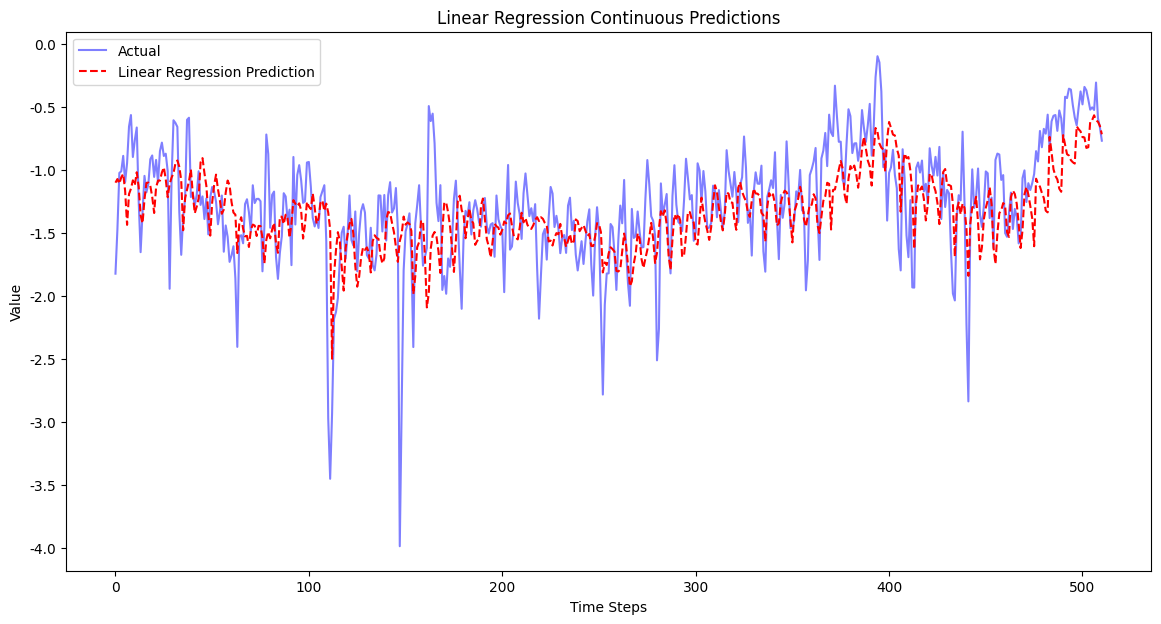

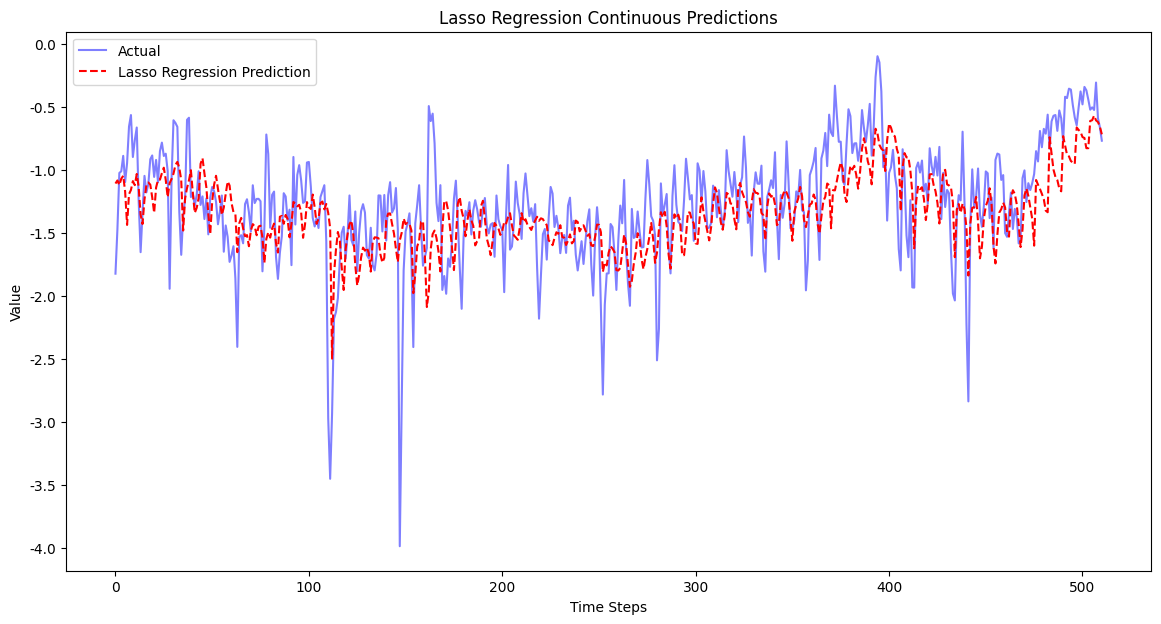

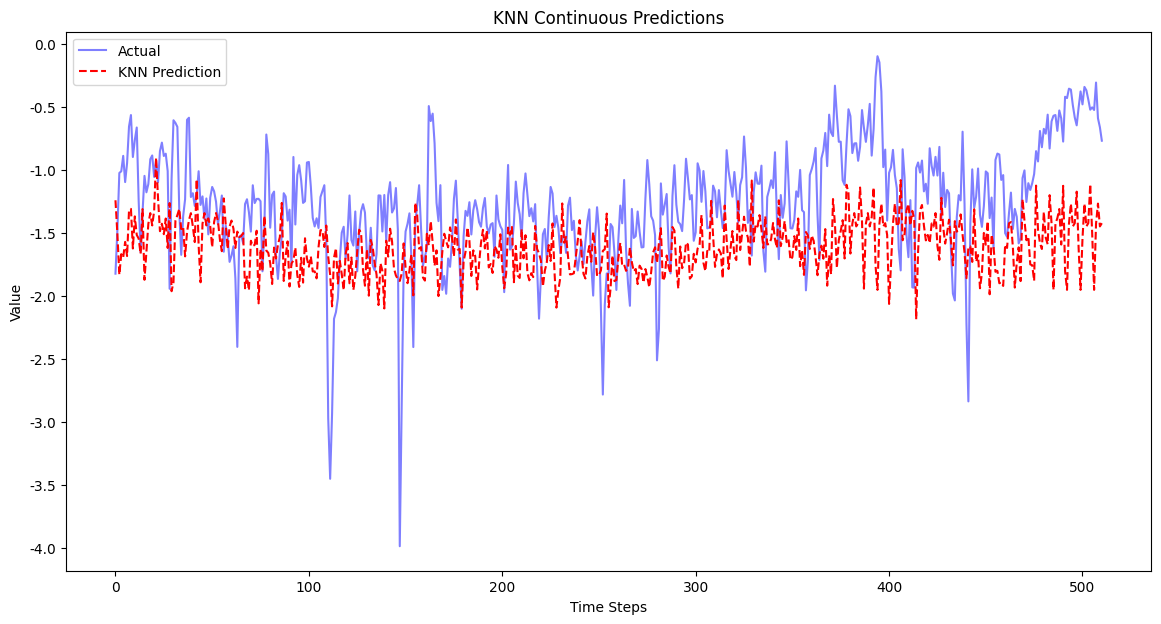

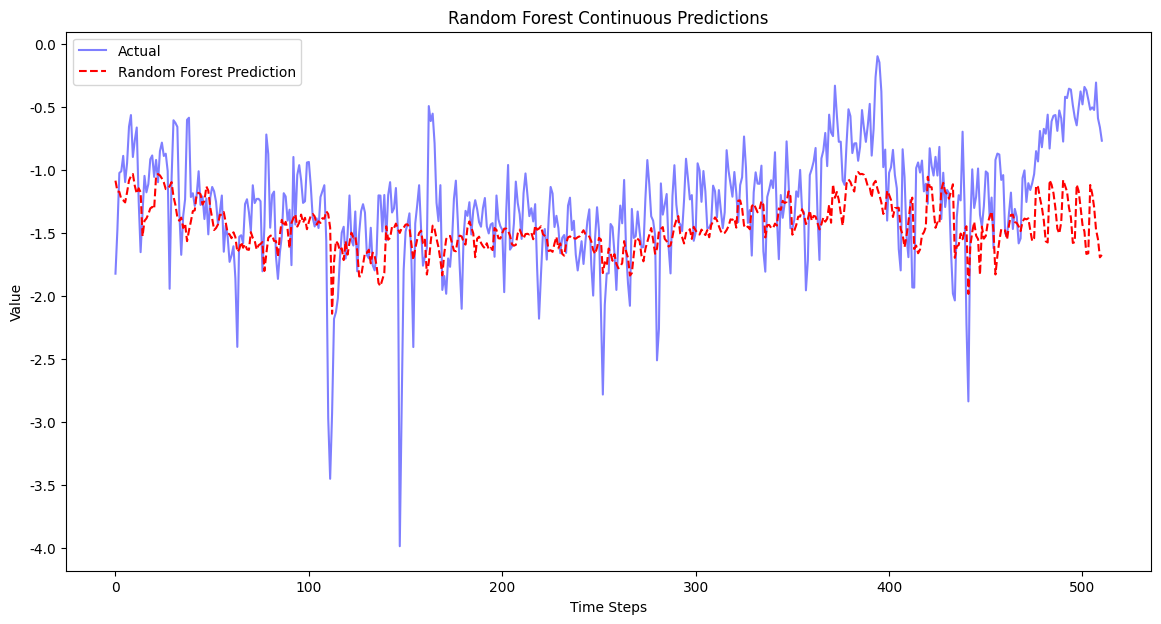

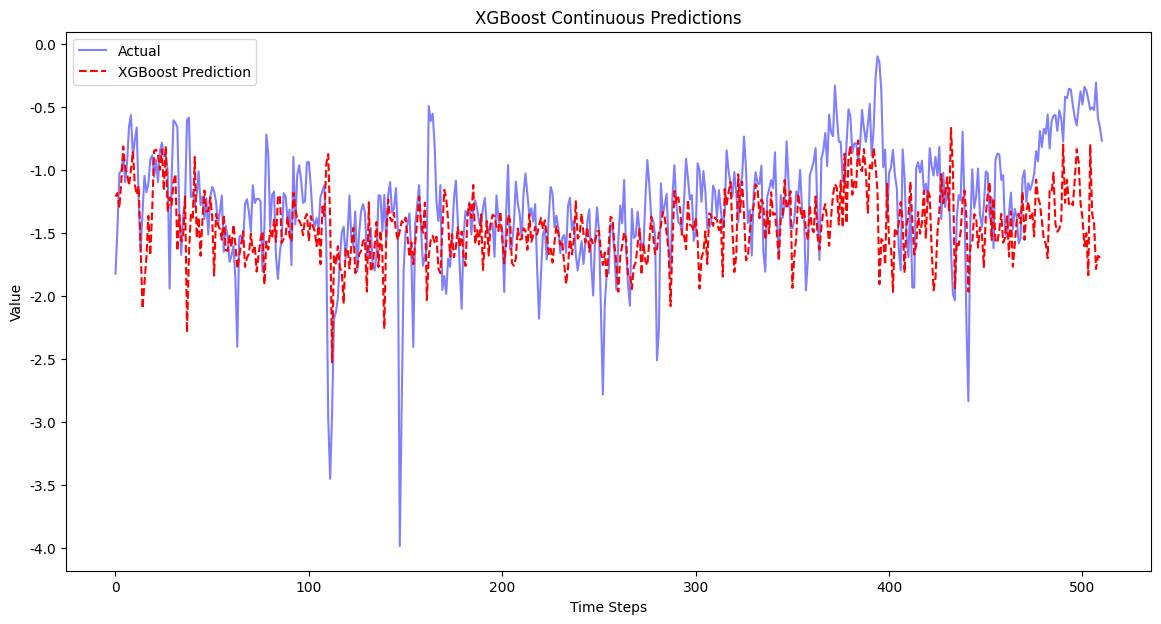

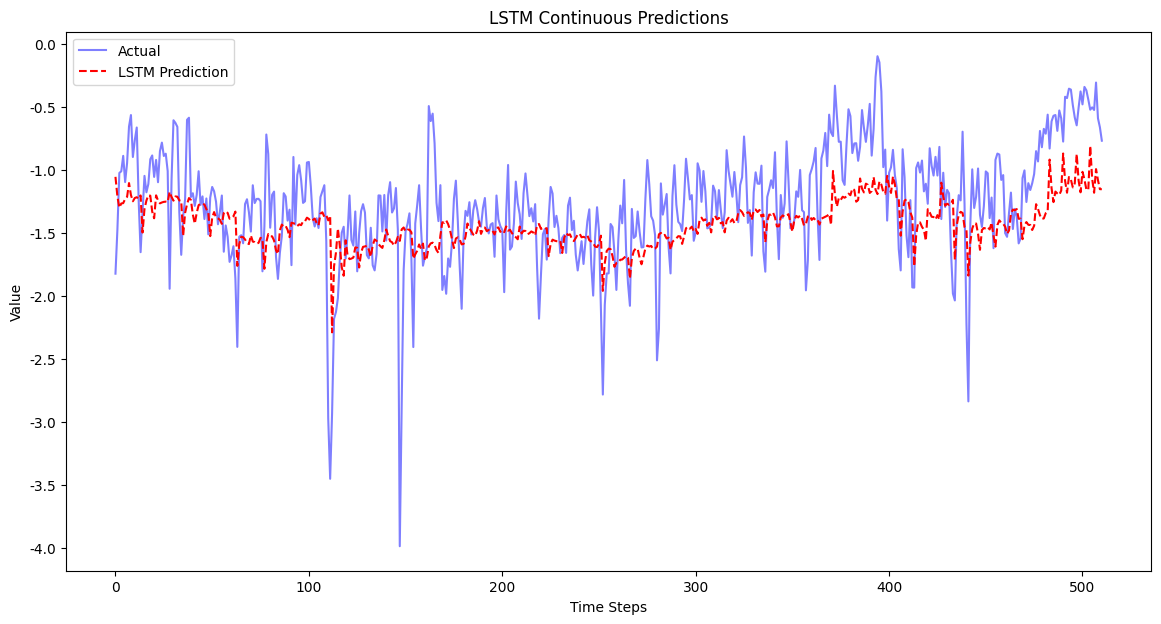

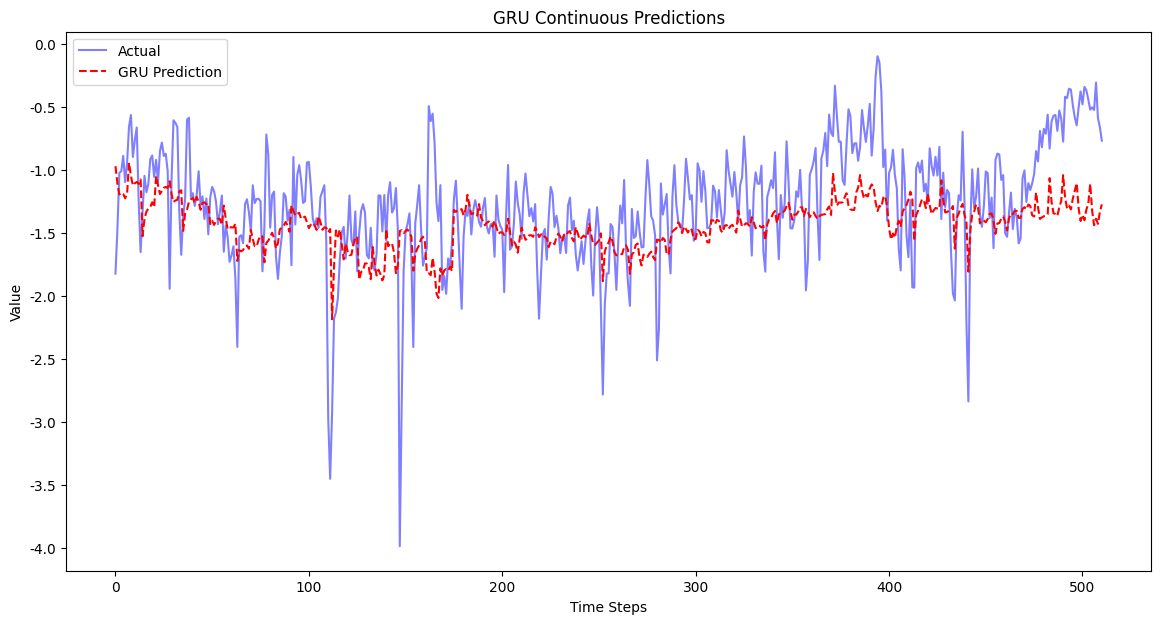

In [5]:
# Plot continuous predictions
def plot_continuous_predictions(y_test, predictions, model_name, forecast_steps):
    # Concatenate predictions and actual values for continuous plotting
    continuous_predictions = np.concatenate(predictions[::forecast_steps])
    continuous_actual = np.concatenate(y_test[::forecast_steps])
    
    plt.figure(figsize=(14, 7))
    plt.plot(continuous_actual, color='blue', label='Actual', alpha=0.5)
    plt.plot(continuous_predictions, linestyle='dashed', color='red', label=f'{model_name} Prediction')
    plt.title(f'{model_name} Continuous Predictions')
    plt.xlabel('Time Steps')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

# Plot predictions for each model
for model_name, predictions in models.items():
    plot_continuous_predictions(y_test, predictions, model_name, forecast_steps)
